In [279]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [280]:
# データセット読み込み
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# # 標準化
# X_train = X_train.reshape(-1, 784)
# X_test = X_test.reshape(-1, 784)

# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255 # (60000, 28, 28) (N, H, W)
X_test /= 255

# チャネル数の軸を追加
X_train = X_train[:, np.newaxis, :, :] # (60000, 1, 28, 28) (N, C, H, W)
X_test = X_test[:, np.newaxis, :, :]

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# ワンホットエンコーディング
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_val[:, np.newaxis])

# 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。

In [281]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

### im2col動作確認 

In [282]:
# サンプルデータ
input_data = np.arange(1, 26).reshape((1, 1, 5, 5))
filter_h = 2
filter_w = 2
stride=1
pad=0

In [283]:
N, C, H, W = input_data.shape
out_h = (H + 2*pad - filter_h)//stride + 1
out_w = (W + 2*pad - filter_w)//stride + 1

img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

check0 = col.copy()

for y in range(filter_h):
    y_max = y + stride*out_h
    for x in range(filter_w):
        x_max = x + stride*out_w
        col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
        
check1 = col.copy()
check2 = check1.transpose(0, 4, 5, 1, 2, 3)

col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)


print('フィルタサイズ２×２の場合\n')
print(img.shape)
print(f'{img}\n')
print('　　　⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎\n')
print(check1.shape)
print(f'{check1}\n')
print('　　　⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎ transpose(0, 4, 5, 1, 2, 3)\n')
print(check2.shape)
print(f'{check2}\n')
print('　　　⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎ reshape(N*out_h*out_w, -1)\n')
print(col.shape)
print(col)

フィルタサイズ２×２の場合

(1, 1, 5, 5)
[[[[ 1  2  3  4  5]
   [ 6  7  8  9 10]
   [11 12 13 14 15]
   [16 17 18 19 20]
   [21 22 23 24 25]]]]

　　　⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎

(1, 1, 2, 2, 4, 4)
[[[[[[ 1.  2.  3.  4.]
     [ 6.  7.  8.  9.]
     [11. 12. 13. 14.]
     [16. 17. 18. 19.]]

    [[ 2.  3.  4.  5.]
     [ 7.  8.  9. 10.]
     [12. 13. 14. 15.]
     [17. 18. 19. 20.]]]


   [[[ 6.  7.  8.  9.]
     [11. 12. 13. 14.]
     [16. 17. 18. 19.]
     [21. 22. 23. 24.]]

    [[ 7.  8.  9. 10.]
     [12. 13. 14. 15.]
     [17. 18. 19. 20.]
     [22. 23. 24. 25.]]]]]]

　　　⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎ transpose(0, 4, 5, 1, 2, 3)

(1, 4, 4, 1, 2, 2)
[[[[[[ 1.  2.]
     [ 6.  7.]]]


   [[[ 2.  3.]
     [ 7.  8.]]]


   [[[ 3.  4.]
     [ 8.  9.]]]


   [[[ 4.  5.]
     [ 9. 10.]]]]



  [[[[ 6.  7.]
     [11. 12.]]]


   [[[ 7.  8.]
     [12. 13.]]]


   [[[ 8.  9.]
     [13. 14.]]]


   [[[ 9. 10.]
     [14. 15.]]]]



  [[[[11. 12.]
     [16. 17.]]]


   [[[12. 13.]
     [17. 18.]]]


   [[[13. 14.]
     [18. 19.]]]




In [284]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [285]:
col2im(col, input_data.shape, 2, 2).shape

(1, 1, 5, 5)

In [286]:
class Conv2d:
    '''
    2次元畳み込み層
    '''
    def __init__(self, W, b, lr=0.05, stride=1, pad=0):
        self.W = W
        self.b = b.astype('float64')
        self.stride = stride
        self.pad = pad
        self.lr = lr
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        # パラメータ更新
        self.update()

        return dx
    
    def update(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db

In [287]:
# サンプルデータ
FN, C, FH, FW = 3, 1, 2, 2
w = np.ones((FN, C, FH, FW))
b = np.ones((FN,))
print(f'・w\n{w}\n')
print(f'・b\n{b}\n')
print(f'・input_data.shape:\n{input_data.shape}')

・w
[[[[1. 1.]
   [1. 1.]]]


 [[[1. 1.]
   [1. 1.]]]


 [[[1. 1.]
   [1. 1.]]]]

・b
[1. 1. 1.]

・input_data.shape:
(1, 1, 5, 5)


In [288]:
co = Conv2d(w, b)

In [289]:
out = co.forward(input_data)
dx = co.backward(out)
print(f'・forward\nout: {out.shape}\n')
print(f'・backward\ndb: {co.db.shape}')
print(f'dw: {co.dW.shape}')
print(f'dx: {dx.shape}')

・forward
out: (1, 3, 4, 4)

・backward
db: (3,)
dw: (3, 1, 2, 2)
dx: (1, 1, 5, 5)


# 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。
$$N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1$$
$$N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1$$
$N_{out}$ : 出力のサイズ（特徴量の数）  
$N_{in}$ : 入力のサイズ（特徴量の数）  
$P$ : ある方向へのパディングの数  
$F$ : フィルタのサイズ  
$S$ : ストライドのサイズ  
$h$ が高さ方向、 $w$ が幅方向である

In [290]:
def out_size(H, W, P, FH, FW, S):
    out_h = (H + 2 * P - FH) // S + 1
    out_w = (W + 2 * P - FW) // S + 1
    return out_h, out_w

# 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）  
$S_{h}$, $S_{w}$ : 高さ方向（h）と幅方向（w）のストライドのサイズ  
$(p,q)\in P_{i,j} : P_{i,j}$ に含まれる行（p）と列（q）のインデックス  
$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値  
$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値  
ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。  
バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス (p,q) を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [291]:
class MaxPool2D:
    '''
    最大プーリング層
    '''
    def __init__(self, pool_h, pool_w, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = pool_h
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

In [292]:
mp = MaxPool2D(2, 2)
mp_out = mp.forward(out)
mp_dx = mp.backward(mp_out)
print(f'out:   {out.shape}')
print(f'mp_out:{mp_out.shape}')
print(f'mp_dx: {mp_dx.shape}')

out:   (1, 3, 4, 4)
mp_out:(1, 3, 2, 2)
mp_dx: (1, 3, 4, 4)


In [293]:
# 元データ
out

array([[[[17., 21., 25., 29.],
         [37., 41., 45., 49.],
         [57., 61., 65., 69.],
         [77., 81., 85., 89.]],

        [[17., 21., 25., 29.],
         [37., 41., 45., 49.],
         [57., 61., 65., 69.],
         [77., 81., 85., 89.]],

        [[17., 21., 25., 29.],
         [37., 41., 45., 49.],
         [57., 61., 65., 69.],
         [77., 81., 85., 89.]]]])

In [294]:
# forward
mp_out

array([[[[41., 49.],
         [81., 89.]],

        [[41., 49.],
         [81., 89.]],

        [[41., 49.],
         [81., 89.]]]])

In [295]:
# backward
mp_dx

array([[[[ 0.,  0.,  0.,  0.],
         [ 0., 41.,  0., 49.],
         [ 0.,  0.,  0.,  0.],
         [ 0., 81.,  0., 89.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0., 41.,  0., 49.],
         [ 0.,  0.,  0.,  0.],
         [ 0., 81.,  0., 89.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0., 41.,  0., 49.],
         [ 0.,  0.,  0.,  0.],
         [ 0., 81.,  0., 89.]]]])

# 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。  
範囲内の最大値ではなく、平均値を出力とするプーリング層です。  
画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

# 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [296]:
class Flatten:
    '''
    平滑化するためのFlattenクラス
    '''
    def forward(self, x):
        N, C, H, W = x.shape
        out = x.reshape(N, -1)
        
        self.x = x
        
        return out
    
    def backward(self, dout):
        dx = dout.reshape(self.x.shape)
        
        return dx

In [297]:
fl = Flatten()
fl_out = fl.forward(out)
fl_dx = fl.backward(fl_out)
print(f'out:     {out.shape}')
print(f'forward: {fl_out.shape}')
print(f'backward:{fl_dx.shape}')

out:     (1, 3, 4, 4)
forward: (1, 48)
backward:(1, 3, 4, 4)


# 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。  
精度は低くともまずは動くことを目指してください。

In [21]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        # 最適化手法
        self.optimizer = optimizer
        # AdaGradの初期値
        self.HW = 0
        self.HB = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.Z = X
        self.A = X @ self.W + self.B
        return self.A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        self.dZ = dA @ self.W.T
        self = self.optimizer.update(self)
        return self.dZ

In [22]:
class SoftmaxWithLoss:
    '''
    ソフトマックス関数と交差エントロピー誤差
    '''
    def forward(self, A):
        """
        フォワード
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            出力
        """ 
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z
        
    def backward(self, Z, y):
        """
        バックワード
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
        y : ラベル  ndarray, shape (batch_size,)
            入力
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        loss : 交差エントロピー誤差
        """
        dA = Z - y
        loss = - np.sum(y * np.log(Z)) / len(y)
        return dA, loss

In [23]:
class Relu:
    '''
    ReLU関数
    '''
    def forward(self, A):
        """
        フォワード
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            出力
        """ 
        self.A = A
        Z = np.maximum(0, A)
        return Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dA = dZ * np.where(self.A > 0, 1, 0)
        return dA

In [24]:
class HeInitializer:
    """
    Heによる初期化
    """
    def __init__(self, sigma):
        _ = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [25]:
class AdaGrad:
    '''
    AdaGradによる最適化
    '''
    def __init__(self, lr):
        self.lr = lr # 学習率
    
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.HW += layer.dW * layer.dW
        layer.HB += layer.dB * layer.dB
        delta = 1e-7 # 0で除算してしまうのを防ぐための値
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.HW) + delta) / len(layer.Z)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.HB) + delta) / len(layer.Z)
        return layer

In [26]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [117]:
class Scratch2dCNNClassifier():
    """
    Conv2d → ReLU → MaxPool2d → Flatten → Affine → Softmax
    """
    def __init__(self, FN=20, FH=7, FW=7, stride=1, pad=0, epoch=1, optimizer=AdaGrad, initializer=HeInitializer, activater=Relu, verbose=False,):
        self.verbose = verbose
        self.batch_size = 60 # バッチサイズ
        self.n_output = 10 # 出力のクラス数
        self.sigma = 0.02 # ガウス分布の標準偏差
        self.lr = 0.05 # 学習率
        self.epoch = epoch # エポック数
        self.optimizer = optimizer # 最適化手法
        self.initializer = initializer # 初期化方法
        self.activater = activater # 活性化関数
        self.FN = FN # 出力チャネル数
        self.C = 1 # 入力チャネル数
        self.FH = FH # フィルター縦幅
        self.FW = FW # フィルター横幅
        self.pool_h = 2 # プーリングフィルタ縦幅
        self.pool_w = 2 # プーリングフィルタ横幅
        self.pad = pad # パディング
        self.stride = stride # ストライド
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = [] # 学習データのloss記録用
        self.loss_val = [] # 検証データのloss記録用
        
        # 全結合層へ流れるnode数を取得
        out_h, out_w = self.out_size(28, 28, self.pad, self.FH, self.FW, self.stride)
        out_h, out_w = self.out_size(out_h, out_w, 0, self.pool_h, self.pool_w, self.pool_h)
        fc_nodes = self.FN * out_h * out_w
        
        # 最適化手法を選択
        optimizer = self.optimizer(self.lr)
        
        # 重みとバイアスの初期値
        w = self.sigma * np.random.randn(self.FN, self.C, self.FH, self.FW)
        b = self.sigma * np.random.randn(self.FN,)
        
        # インスタンス化
        self.cv = Conv2d(w, b, stride=self.stride, pad=self.pad)
        self.activation_cv = self.activater()
        self.pl = MaxPool2D(self.pool_h, self.pool_w)
        self.fl = Flatten()
        self.FC = FC(fc_nodes, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation_fc = SoftmaxWithLoss()
        
        # 学習
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for mini_X, mini_y in get_mini_batch:

                # フォワード
                A1 = self.cv.forward(mini_X)
                Z1 = self.activation_cv.forward(A1)
                P1 = self.pl.forward(Z1)
                F1 = self.fl.forward(P1)
                A2 = self.FC.forward(F1)
                Z2 = self.activation_fc.forward(A2)

                # バックワード
                dA2, loss = self.activation_fc.backward(Z2, mini_y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC.backward(dA2)
                dF1 = self.fl.backward(dZ2)
                dP1 = self.pl.backward(dF1)
                dA1 = self.activation_cv.backward(dP1)
                dZ1 = self.cv.backward(dA1)
                
            # エポックごとに交差エントロピー誤差を記録
            if self.verbose:
                A1 = self.cv.forward(X)
                Z1 = self.activation_cv.forward(A1)
                P1 = self.pl.forward(Z1)
                F1 = self.fl.forward(P1)
                A2 = self.FC.forward(F1)
                Z2 = self.activation_fc.forward(A2)  
                self.loss_train.append(self.activation_fc.backward(Z2, y)[1])
                
                if X_val is not None:
                    A1 = self.cv.forward(X_val)
                    Z1 = self.activation_cv.forward(A1)
                    P1 = self.pl.forward(Z1)
                    F1 = self.fl.forward(P1)
                    A2 = self.FC.forward(F1)
                    Z2 = self.activation_fc.forward(A2)         
                    self.loss_val.append(self.activation_fc.backward(Z2, y_val)[1])
                    
    def out_size(self, H, W, P, FH, FW, S):
        out_h = (H + 2 * P - FH) // S + 1
        out_w = (W + 2 * P - FW) // S + 1
        return out_h, out_w
    
    def predict(self, X):
        A1 = self.cv.forward(X)
        Z1 = self.activation_cv.forward(A1)
        P1 = self.pl.forward(Z1)
        F1 = self.fl.forward(P1)
        A2 = self.FC.forward(F1)
        Z2 = self.activation_fc.forward(A2)
        return np.argmax(Z2, axis=1)

# 検証

## ① フィルタサイズとAccuracy

In [116]:
for i in [3, 5, 7, 9]:
    cnn1 = Scratch2dCNNClassifier(FN=5,
                                  FH=i,
                                  FW=i,
                                  stride=1,
                                  pad=0
                                 )
    cnn1.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)
    pred1 = cnn1.predict(X_val)
    print(f'フィルタサイズ{i}×{i}：{accuracy_score(y_val, pred1)}')

フィルタサイズ3×3：0.804
フィルタサイズ5×5：0.74725
フィルタサイズ7×7：0.85525
フィルタサイズ9×9：0.8431666666666666


- 7×7が優秀

## ② ストライドとAccuracy

In [29]:
for i in [2, 3, 7]:
    cnn1 = Scratch2dCNNClassifier(FN=5,
                                  FH=7,
                                  FW=7,
                                  stride=i,
                                  pad=0
                                 )
    cnn1.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)
    pred1 = cnn1.predict(X_val)
    print(f'ストライド{i}：{accuracy_score(y_val, pred1)}')

ストライド2：0.11366666666666667
ストライド3：0.10783333333333334
ストライド7：0.18866666666666668


- ストライドは1で良さそう。

## ③ パディングとAccuracy

In [30]:
for i in [1, 2, 3]:
    cnn1 = Scratch2dCNNClassifier(FN=5,
                                  FH=7,
                                  FW=7,
                                  stride=1,
                                  pad=i
                                 )
    cnn1.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)
    pred1 = cnn1.predict(X_val)
    print(f'パディング{i}：{accuracy_score(y_val, pred1)}')

パディング1：0.7855
パディング2：0.8375
パディング3：0.8336666666666667


- パディング2が優秀

## ④ フィルターとエポック数を増やして精度がどこまで出るか

In [31]:
%%time
cnn = Scratch2dCNNClassifier(FN=20,
                             FH=7, 
                             FW=7,
                             stride=1,
                             pad=2,
                             epoch=10,
                             verbose=True
                             )
cnn.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)

CPU times: user 28min 57s, sys: 43min 52s, total: 1h 12min 49s
Wall time: 2h 1min 53s


In [32]:
pred = cnn.predict(X_val)
accuracy_score(y_val, pred)

0.9718333333333333

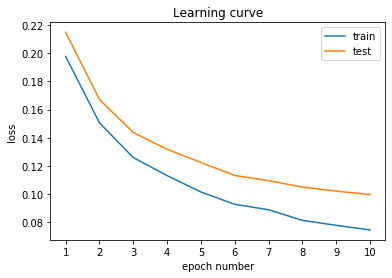

In [33]:
# 学習曲線
plt.title('Learning curve')
plt.xlabel('epoch number')
plt.ylabel('loss')
plt.plot(list(range(1, cnn.epoch+1)), cnn.loss_train, label='train')
plt.plot(list(range(1, cnn.epoch+1)), cnn.loss_val, label='test')
plt.legend()
plt.xticks(list(range(1, cnn.epoch+1)));

- 学習を続ければまだ下がりそうだが、DNNと比較して学習時間と精度のコスパが悪い。

# 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。
サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。


- 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
- ReLU
- 最大プーリング
- 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
- ReLU
- 最大プーリング
- 平滑化
- 全結合層　出力ノード数120
- ReLU
- 全結合層　出力ノード数84
- ReLU
- 全結合層　出力ノード数10
- ソフトマックス関数

In [249]:
class Conv2d2:
    '''
    2次元畳み込み層
    '''
    def __init__(self, FN, C, FH, FW, lr=0.003, stride=1, pad=0, sigma=0.002):
        self.W = sigma * np.random.randn(FN, C, FH, FW)
        self.b = sigma * np.random.randn(FN,).astype('float64')
        self.stride = stride
        self.pad = pad
        self.lr = lr
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        # パラメータ更新
        self.update()

        return dx
    
    def update(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db

In [250]:
class LeNet():
    """
    LeNetクラス
    """
    def __init__(self, epoch=1, optimizer=AdaGrad, initializer=HeInitializer, activater=Relu, verbose=False,):
        self.verbose = verbose
        self.batch_size = 20 # バッチサイズ
        self.n_output = 10 # 出力のクラス数
        self.sigma = 0.02 # ガウス分布の標準偏差
        self.lr = 0.003 # 学習率
        self.epoch = epoch # エポック数
        self.optimizer = optimizer # 最適化手法
        self.initializer = initializer # 初期化方法
        self.activater = activater # 活性化関数
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = [] # 学習データのloss記録用
        self.loss_val = [] # 検証データのloss記録用
        
        # 最適化手法を選択
        optimizer = self.optimizer(self.lr)
        
        # インスタンス化
        self.cv1 = Conv2d2(6, 1, 5, 5)
        self.activation_cv1 = self.activater()
        self.pl1 = MaxPool2D(2, 2)
        self.cv2 = Conv2d2(16, 6, 5, 5)
        self.activation_cv2 = self.activater()
        self.pl2 = MaxPool2D(2, 2)
        self.fl = Flatten()
        self.FC1 = FC(256, 120, self.initializer(self.sigma), optimizer)
        self.activation_fc1 = self.activater()
        self.FC2 = FC(120, 84, self.initializer(self.sigma), optimizer)
        self.activation_fc2 = self.activater()
        self.FC3 = FC(84, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation_fc3 = SoftmaxWithLoss()
        
        # 学習
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for mini_X, mini_y in get_mini_batch:

                # フォワード
                A1 = self.cv1.forward(mini_X)
                Z1 = self.activation_cv1.forward(A1)
                P1 = self.pl1.forward(Z1)
                A2 = self.cv2.forward(P1)
                Z2 = self.activation_cv2.forward(A2)
                P2 = self.pl2.forward(Z2)
                F1 = self.fl.forward(P2)
                A3 = self.FC1.forward(F1)
                Z3 = self.activation_fc1.forward(A3)
                A4 = self.FC2.forward(Z3)
                Z4 = self.activation_fc2.forward(A4)
                A5 = self.FC3.forward(Z4)
                Z5 = self.activation_fc3.forward(A5)

                # バックワード
                dA5, loss = self.activation_fc3.backward(Z5, mini_y)
                dZ4 = self.FC3.backward(dA5)
                dA4 = self.activation_fc2.backward(dZ4)
                dZ3 = self.FC2.backward(dA4)
                dA3 = self.activation_fc1.backward(dZ3)
                dZ2 = self.FC1.backward(dA3)
                dF1 = self.fl.backward(dZ2)
                dP2 = self.pl2.backward(dF1)
                dZ1 = self.activation_cv2.backward(dP2)
                dA1 = self.cv2.backward(dZ1)
                dP1 = self.pl1.backward(dA1)
                dZ0 = self.activation_cv1.backward(dP1)
                dA0 = self.cv1.backward(dZ0)
                
            # エポックごとに交差エントロピー誤差を記録
            if self.verbose:
                A1 = self.cv1.forward(X)
                Z1 = self.activation_cv1.forward(A1)
                P1 = self.pl1.forward(Z1)
                A2 = self.cv2.forward(P1)
                Z2 = self.activation_cv2.forward(A2)
                P2 = self.pl2.forward(Z2)
                F1 = self.fl.forward(P2)
                A3 = self.FC1.forward(F1)
                Z3 = self.activation_fc1.forward(A3)
                A4 = self.FC2.forward(Z3)
                Z4 = self.activation_fc2.forward(A4)
                A5 = self.FC3.forward(Z4)
                Z5 = self.activation_fc3.forward(A5) 
                self.loss_train.append(self.activation_fc3.backward(Z5, y)[1])
                
                if X_val is not None:
                    A1 = self.cv1.forward(X_val)
                    Z1 = self.activation_cv1.forward(A1)
                    P1 = self.pl1.forward(Z1)
                    A2 = self.cv2.forward(P1)
                    Z2 = self.activation_cv2.forward(A2)
                    P2 = self.pl2.forward(Z2)
                    F1 = self.fl.forward(P2)
                    A3 = self.FC1.forward(F1)
                    Z3 = self.activation_fc1.forward(A3)
                    A4 = self.FC2.forward(Z3)
                    Z4 = self.activation_fc2.forward(A4)
                    A5 = self.FC3.forward(Z4)
                    Z5 = self.activation_fc3.forward(A5)        
                    self.loss_val.append(self.activation_fc3.backward(Z5, y_val)[1])
                    
    def out_size(self, H, W, P, FH, FW, S):
        out_h = (H + 2 * P - FH) // S + 1
        out_w = (W + 2 * P - FW) // S + 1
        return out_h, out_w
    
    def predict(self, X):
        A1 = self.cv1.forward(X)
        Z1 = self.activation_cv1.forward(A1)
        P1 = self.pl1.forward(Z1)
        A2 = self.cv2.forward(P1)
        Z2 = self.activation_cv2.forward(A2)
        P2 = self.pl2.forward(Z2)
        F1 = self.fl.forward(P2)
        A3 = self.FC1.forward(F1)
        Z3 = self.activation_fc1.forward(A3)
        A4 = self.FC2.forward(Z3)
        Z4 = self.activation_fc2.forward(A4)
        A5 = self.FC3.forward(Z4)
        Z5 = self.activation_fc3.forward(A5)
        return np.argmax(Z5, axis=1)

In [252]:
lenet = LeNet(verbose=True, epoch=10)
lenet.fit(X_train[:2000], y_train_one_hot[:2000], X_val[:500], y_test_one_hot[:500])
pred2 = lenet.predict(X_val[:500])
accuracy_score(y_val[:500], pred2)

0.788

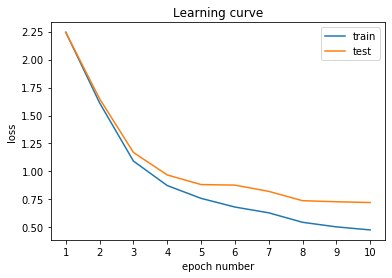

In [253]:
# 学習曲線
plt.title('Learning curve')
plt.xlabel('epoch number')
plt.ylabel('loss')
plt.plot(list(range(1, lenet.epoch+1)), lenet.loss_train, label='train')
plt.plot(list(range(1, lenet.epoch+1)), lenet.loss_val, label='test')
plt.legend()
plt.xticks(list(range(1, lenet.epoch+1)));

- LeNetは精度が悪い。

# 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。
どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

![aa](https://gyazo.com/180966a9d52b71a3629f41284f516e54.gng)

# 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

In [34]:
def out_size(H, W, P, FH, FW, S):
    out_h = (H + 2 * P - FH) // S + 1
    out_w = (W + 2 * P - FW) // S + 1
    return out_h, out_w

# フィルターの縦 * フィルターの横 * 入力のチャンネル数 * 出力のチャンネル数 + バイアス(1チャンネルごとに1つ)
def parm_n(FH, FW, C, FN):
    return FH*FW*C*FN + FN

1.
- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

In [35]:
print(f'出力サイズ：{out_size(144, 144, 0, 3, 3, 1)}')
print(f'パラメータ数：{parm_n(3, 3, 3, 6)}')

出力サイズ：(142, 142)
パラメータ数：168


2.
- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

In [36]:
print(f'出力サイズ：{out_size(60, 60, 0, 3, 3, 1)}')
print(f'パラメータ数：{parm_n(3, 3, 24, 48)}')

出力サイズ：(58, 58)
パラメータ数：10416


3.
- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

In [37]:
out_size(20, 20, 0, 3, 3, 2)
print(f'出力サイズ：{out_size(20, 20, 0, 3, 3, 2)}')
print(f'パラメータ数：{parm_n(3, 3, 10, 20)}')

出力サイズ：(9, 9)
パラメータ数：1820


# 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1×1のフィルタの効果

## 解答
- 小さいフィルタを使うことでパラメータ数を削減でき、モデルの高速化につながるから。

### 例
![d](https://gyazo.com/b201bec639f8ff9175ad103b068e0b8c.gng)
パラメータ数：32×3×3×64+64=18496個  

これに、1×1のフィルターを挟むと・・・
![da](https://gyazo.com/08e4eaea79a61e496238104db04941a4.gng)
- 最初の畳み込み層:32×1×1×16+16=528
- 次の畳み込み層:16×3×3×64+64=9280
### 計：9808個